In [1]:
from IMPORTS import *

c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounte

In [2]:
Embedding_name="word2vec"
Dataset="ATE"

In [3]:
seed_value = 18
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [4]:
word2vec = KeyedVectors.load_word2vec_format('WordEmbeddings/Word2Vec.bin',binary=True)

# Data Extraction and Preprocessing

Reading ATE json files

In [5]:
train = None
test = None
val = None
with open(f"Data\processed\{Dataset}_train.json") as f1:
    train = json.load(f1)

with open(f"Data\processed\{Dataset}_test.json") as f2:
    test = json.load(f2)

with open(f"Data\processed\{Dataset}_val.json") as f3:
    val = json.load(f3)



processing into lists

In [6]:
X_train,Y_train = create_train_test_val(train)
X_test,Y_test = create_train_test_val(test)
X_val,Y_val = create_train_test_val(val)

Tokenizing the ATE Dataset

In [7]:
X_train_tokenized, toke = TokenCreator(X_train,1)
X_test_tokenized = TokenCreator(X_test,0,tokenizer = toke)
X_val_tokenized = TokenCreator(X_val,0,tokenizer = toke)

Y_train_tokenized,toke2 = TokenCreator(Y_train,0)
Y_test_tokenized = TokenCreator(Y_test,0,tokenizer = toke2)
Y_val_tokenized = TokenCreator(Y_val,0,tokenizer = toke2)

Vocabulary of ATE

In [8]:
st1 = find_vocab(X_train_tokenized)
vocab_size  = len(st1) + 1 
vocab_size

2406

In [9]:
max_len=0

for i in X_train_tokenized:
    max_len = max(max_len,len(i))

max_len

78

Padding ATE

In [10]:
X_padded_train = pad_sequences(X_train_tokenized, maxlen=max_len, padding="pre", truncating="post")
Y_padded_train = pad_sequences(Y_train_tokenized, maxlen=max_len, padding="pre", truncating="post")

X_padded_test = pad_sequences(X_test_tokenized, maxlen=max_len, padding="pre", truncating="post")
Y_padded_test = pad_sequences(Y_test_tokenized, maxlen=max_len, padding="pre", truncating="post")

X_padded_val = pad_sequences(X_val_tokenized, maxlen=max_len, padding="pre", truncating="post")
Y_padded_val = pad_sequences(Y_val_tokenized, maxlen=max_len, padding="pre", truncating="post")       

One hot encoding the ATE labels

In [11]:
Y_padded_train = to_categorical(Y_padded_train)
Y_padded_test = to_categorical(Y_padded_test)
Y_padded_val = to_categorical(Y_padded_val)

Assigning **ATE Word2Vec** mapping

In [12]:
weights = np.zeros((vocab_size, 300))
mapping = toke.word_index 
mapping

{'#UK': 1,
 'the': 2,
 '.': 3,
 ',': 4,
 'and': 5,
 'it': 6,
 'to': 7,
 'i': 8,
 'is': 9,
 'a': 10,
 'of': 11,
 'for': 12,
 'with': 13,
 'that': 14,
 'my': 15,
 'you': 16,
 'this': 17,
 'was': 18,
 'in': 19,
 'not': 20,
 'on': 21,
 'very': 22,
 'but': 23,
 'computer': 24,
 'use': 25,
 'have': 26,
 'great': 27,
 'they': 28,
 'laptop': 29,
 "n't": 30,
 'so': 31,
 'has': 32,
 'are': 33,
 'battery': 34,
 'had': 35,
 'screen': 36,
 ')': 37,
 'be': 38,
 'as': 39,
 'all': 40,
 '!': 41,
 '(': 42,
 "'s": 43,
 'also': 44,
 'me': 45,
 'just': 46,
 'easy': 47,
 'when': 48,
 'at': 49,
 'or': 50,
 'only': 51,
 'which': 52,
 'up': 53,
 'life': 54,
 'can': 55,
 'windows': 56,
 'than': 57,
 'out': 58,
 'if': 59,
 'do': 60,
 'after': 61,
 'more': 62,
 'keyboard': 63,
 'would': 64,
 'drive': 65,
 'hard': 66,
 'price': 67,
 'from': 68,
 'well': 69,
 'because': 70,
 'good': 71,
 'one': 72,
 'an': 73,
 'like': 74,
 'mac': 75,
 'about': 76,
 'quality': 77,
 'its': 78,
 'love': 79,
 'get': 80,
 'no': 81,
 'so

Fetching weights from pre trained Word2Vec model (ATE)

In [13]:
for word, index in mapping.items():
    if word in word2vec:
        weights[index:] = word2vec[word]

In [14]:
X_train= X_padded_train
Y_train = Y_padded_train
X_test = X_padded_test
Y_test = Y_padded_test
X_val = X_padded_val
Y_val = Y_padded_val
weights = weights
word_token = toke
tag_token = toke2

# Models

## RNN

In [15]:
model_name="RNN"

### Training

In [16]:
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim = vocab_size,output_dim = 300,input_length  = max_len,weights = [weights],trainable = False))
rnn_model.add(SimpleRNN(64, return_sequences=True))
rnn_model.add(TimeDistributed(Dense(Y_train.shape[2], activation='softmax')))

Compiling the rnn Word2Vec Model

In [17]:
rnn_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc',Precision(),Recall()])

In [18]:
rnn_f1_callback = F1ScoreCallback(val_data=(X_val, Y_val),data=(X_train, Y_train))


In [19]:
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 78, 300)           721800    
                                                                 
 simple_rnn (SimpleRNN)      (None, 78, 64)            23360     
                                                                 
 time_distributed (TimeDist  (None, 78, 4)             260       
 ributed)                                                        
                                                                 
Total params: 745420 (2.84 MB)
Trainable params: 23620 (92.27 KB)
Non-trainable params: 721800 (2.75 MB)
_________________________________________________________________


Fitting the rnn model

In [20]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=15, validation_data=(X_val, Y_val), callbacks=[rnn_f1_callback])

Epoch 1/15


29/29 [==============================] - 0s 4ms/step
Val F1 Score: 0.41528981963319084 - Train F1 Score: 0.4226267372542025
8/8 [==============================] - 5s 309ms/step - loss: 1.1186 - acc: 0.8756 - precision: 0.9290 - recall: 0.1614 - val_loss: 0.6321 - val_acc: 0.8847 - val_precision: 0.9034 - val_recall: 0.6862
Epoch 2/15
29/29 [==============================] - 0s 6ms/step
Val F1 Score: 0.4598844194471922 - Train F1 Score: 0.46013816224667753
8/8 [==============================] - 2s 241ms/step - loss: 0.4931 - acc: 0.9106 - precision: 0.9170 - recall: 0.7838 - val_loss: 0.3459 - val_acc: 0.9336 - val_precision: 0.9320 - val_recall: 0.8520
Epoch 3/15
29/29 [==============================] - 0s 6ms/step
Val F1 Score: 0.4776600923612363 - Train F1 Score: 0.478067459242879
8/8 [==============================] - 2s 239ms/step - loss: 0.2954 - acc: 0.9464 - precision: 0.9447 - recall: 0.8808 - val_loss: 0.2332 - val_acc: 0.9625 - val_precision: 0.9626 - val_recall:

Plotting the graph

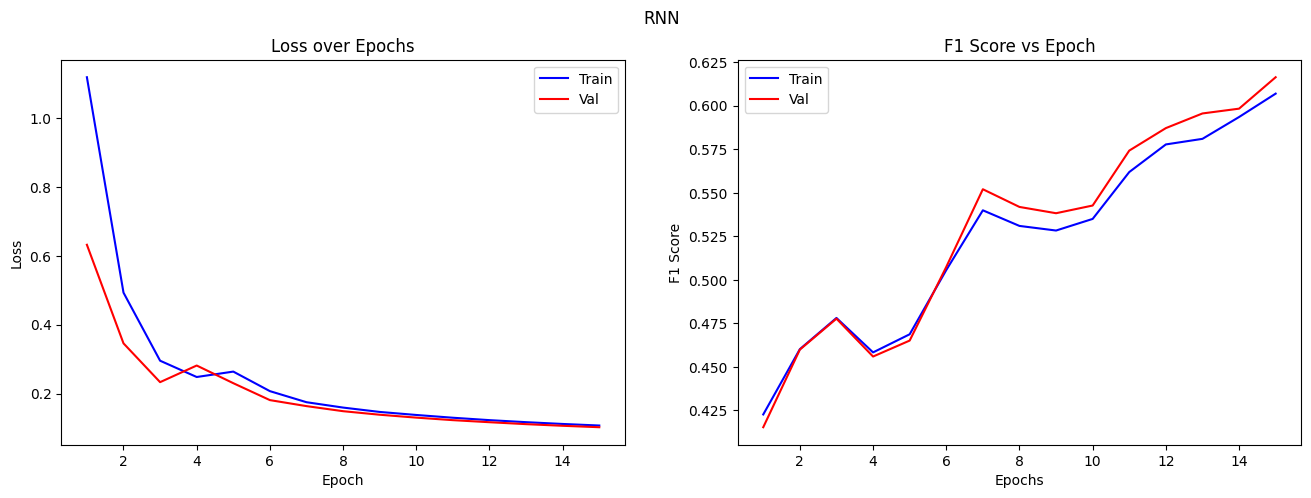

In [21]:
draw_loss_graph(rnn_training,model_name, rnn_f1_callback.train_f1_scores, rnn_f1_callback.val_f1_scores)
save_model(rnn_model,model_name,Embedding_name,Dataset)

### Testing

In [22]:
loaded_model = load_model(model_name,Embedding_name,Dataset)

Testing accuracy

In [23]:
accuracy = loaded_model.evaluate(X_test, Y_test, verbose = 1)
print(accuracy[1])

11/11 [==============================] - 1s 5ms/step - loss: 0.1104 - acc: 0.9740 - precision: 0.9775 - recall: 0.9460
0.9740462899208069


Testing F1 Score

In [24]:
Y_pred = loaded_model.predict(X_test)
real = get_real(Y_test)
pred = get_pred(Y_pred)

true_labels_flat = [label for sublist in real for label in sublist]
predicted_labels_flat = [label for sublist in pred for label in sublist]

# Compute F1 score
f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')

print("Test F1 Score:", f1)

11/11 [==============================] - 0s 5ms/step
Test F1 Score: 0.586243761101982


## GRU

In [25]:
model_name="GRU"

### Training

In [26]:
gru_model = Sequential()
gru_model.add(Embedding(input_dim = vocab_size,output_dim = 300,input_length  = max_len,weights = [weights],trainable = False))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(TimeDistributed(Dense(Y_train.shape[2], activation='softmax')))

compiling 

In [27]:
gru_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc',Precision(),Recall()])

In [28]:
gru_f1_callback = F1ScoreCallback(val_data=(X_val, Y_val),data=(X_train, Y_train))

In [29]:
gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 78, 300)           721800    
                                                                 
 gru (GRU)                   (None, 78, 64)            70272     
                                                                 
 time_distributed_1 (TimeDi  (None, 78, 4)             260       
 stributed)                                                      
                                                                 
Total params: 792332 (3.02 MB)
Trainable params: 70532 (275.52 KB)
Non-trainable params: 721800 (2.75 MB)
_________________________________________________________________


Fitting GRU

In [30]:
gru_training = gru_model.fit(X_train, Y_train, batch_size=128, epochs=15, validation_data=(X_val, Y_val), callbacks=[gru_f1_callback])

Epoch 1/15
29/29 [==============================] - 0s 7ms/step
Val F1 Score: 0.4870890574965421 - Train F1 Score: 0.4867528983090642
8/8 [==============================] - 6s 396ms/step - loss: 1.2884 - acc: 0.9546 - precision_1: 0.9892 - recall_1: 0.0026 - val_loss: 1.1635 - val_acc: 0.9761 - val_precision_1: 0.9539 - val_recall_1: 0.1235
Epoch 2/15
29/29 [==============================] - 0s 7ms/step
Val F1 Score: 0.4871092883135739 - Train F1 Score: 0.4868034938606344
8/8 [==============================] - 2s 241ms/step - loss: 1.0821 - acc: 0.9753 - precision_1: 0.9151 - recall_1: 0.1903 - val_loss: 0.9661 - val_acc: 0.9761 - val_precision_1: 0.9053 - val_recall_1: 0.2088
Epoch 3/15
29/29 [==============================] - 0s 7ms/step
Val F1 Score: 0.4869153104436049 - Train F1 Score: 0.48666110914996225
8/8 [==============================] - 2s 266ms/step - loss: 0.8829 - acc: 0.9753 - precision_1: 0.9012 - recall_1: 0.2128 - val_loss: 0.7157 - val_acc: 0.9758 - val_precision_1: 

Plotting Graph

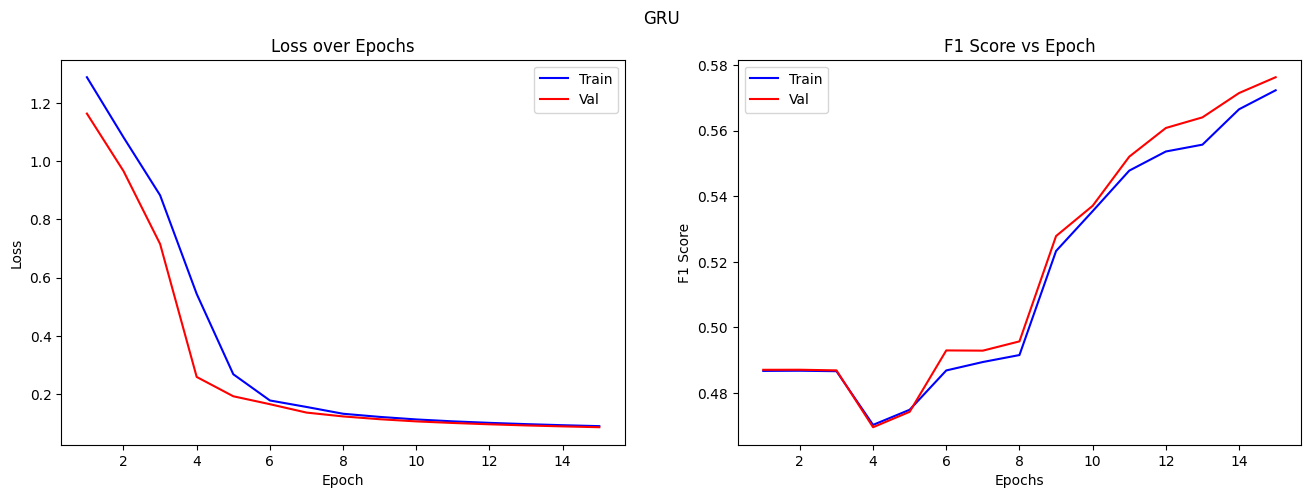

In [31]:
draw_loss_graph(gru_training,model_name, gru_f1_callback.train_f1_scores, gru_f1_callback.val_f1_scores)
save_model(gru_model,model_name,Embedding_name,Dataset)

### Testing

In [32]:
loaded_model = load_model(model_name,Embedding_name,Dataset)

Testing Accuracy

In [33]:
accuracy = loaded_model.evaluate(X_test, Y_test, verbose = 1)
print(accuracy[1])

11/11 [==============================] - 2s 8ms/step - loss: 0.0966 - acc: 0.9753 - precision_1: 0.9796 - recall_1: 0.9593
0.9753361344337463


Testing F1 Score

In [34]:
Y_pred = loaded_model.predict(X_test)
real = get_real(Y_test)
pred = get_pred(Y_pred)

true_labels_flat = [label for sublist in real for label in sublist]
predicted_labels_flat = [label for sublist in pred for label in sublist]

# Compute F1 score
f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')

print("Test F1 Score:", f1)

11/11 [==============================] - 1s 10ms/step
Test F1 Score: 0.5699582538580203


# LSTM

In [35]:
model_name="LSTM"

### Training

In [36]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim = vocab_size,output_dim = 300,input_length  = max_len,weights = [weights],trainable = False))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(TimeDistributed(Dense(Y_train.shape[2], activation='softmax')))# Lstm

Compiling LSTM

In [37]:
lstm_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc',Precision(),Recall()])

In [38]:
LSTM_f1_callback=F1ScoreCallback(val_data=(X_val, Y_val),data=(X_train, Y_train))

In [39]:
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 78, 300)           721800    
                                                                 
 lstm (LSTM)                 (None, 78, 64)            93440     
                                                                 
 time_distributed_2 (TimeDi  (None, 78, 4)             260       
 stributed)                                                      
                                                                 
Total params: 815500 (3.11 MB)
Trainable params: 93700 (366.02 KB)
Non-trainable params: 721800 (2.75 MB)
_________________________________________________________________


Fitting LSTM

In [40]:
lstm_training = lstm_model.fit(X_train, Y_train, batch_size=128, epochs=15, validation_data=(X_val, Y_val), callbacks=[LSTM_f1_callback])

Epoch 1/15
29/29 [==============================] - 0s 9ms/step
Val F1 Score: 0.48697608266573783 - Train F1 Score: 0.4866735247697377
8/8 [==============================] - 7s 530ms/step - loss: 1.3150 - acc: 0.9324 - precision_2: 0.9626 - recall_2: 0.0055 - val_loss: 1.1832 - val_acc: 0.9758 - val_precision_2: 0.9298 - val_recall_2: 0.1381
Epoch 2/15
29/29 [==============================] - 0s 8ms/step
Val F1 Score: 0.4869332174020471 - Train F1 Score: 0.4867028267299759
8/8 [==============================] - 2s 280ms/step - loss: 1.1020 - acc: 0.9752 - precision_2: 0.9115 - recall_2: 0.1792 - val_loss: 0.9783 - val_acc: 0.9757 - val_precision_2: 0.9122 - val_recall_2: 0.2000
Epoch 3/15
29/29 [==============================] - 0s 12ms/step
Val F1 Score: 0.41473805687432175 - Train F1 Score: 0.41971216641303477
8/8 [==============================] - 2s 314ms/step - loss: 0.8045 - acc: 0.9610 - precision_2: 0.9228 - recall_2: 0.3804 - val_loss: 0.5588 - val_acc: 0.8865 - val_precision_

Plotting Graph

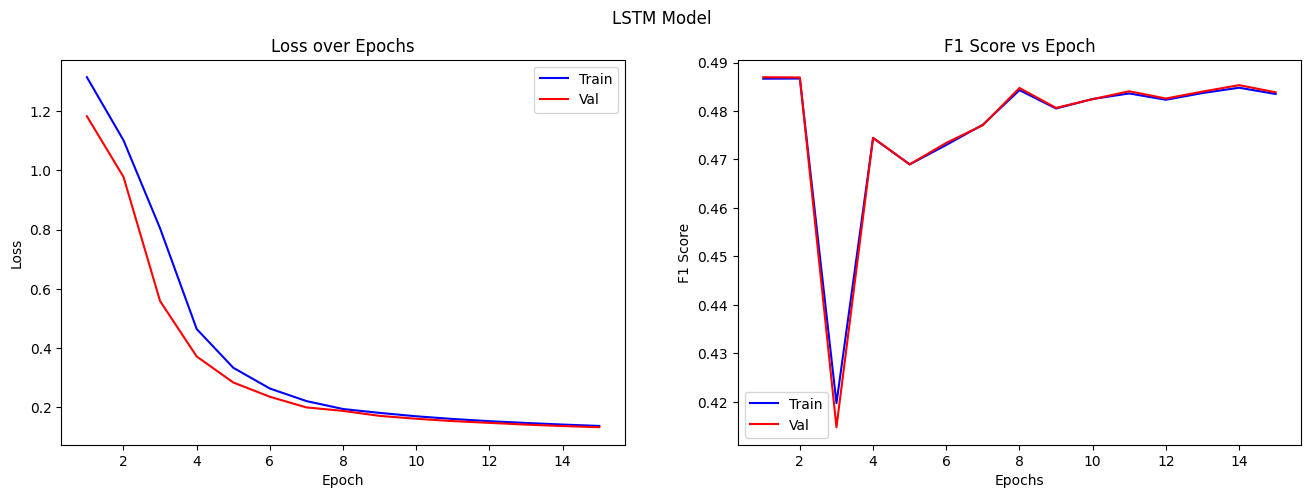

In [42]:
draw_loss_graph(lstm_training, "LSTM Model", LSTM_f1_callback.train_f1_scores, LSTM_f1_callback.val_f1_scores)
save_model(lstm_model, model_name, Embedding_name, Dataset)
loaded_model = load_model(model_name,Embedding_name,Dataset)

### Testing

In [43]:
loaded_model = load_model(model_name,Embedding_name,Dataset)

Testing accuracy

In [44]:
accuracy = loaded_model.evaluate(X_test, Y_test, verbose = 1)
print(accuracy[1])

11/11 [==============================] - 1s 11ms/step - loss: 0.1389 - acc: 0.9700 - precision_2: 0.9697 - recall_2: 0.9308
0.9700203537940979


Testing F1 Score

In [45]:
Y_pred = loaded_model.predict(X_test)
real = get_real(Y_test)
pred = get_pred(Y_pred)

true_labels_flat = [label for sublist in real for label in sublist]
predicted_labels_flat = [label for sublist in pred for label in sublist]

# Compute F1 score
f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')

print("Test F1 Score:", f1)

11/11 [==============================] - 1s 10ms/step
Test F1 Score: 0.4802295070698823


# BiLSTM

In [46]:
model_name="BiLSTM"

Training

In [47]:
input=Input(shape=(max_len,))
BiLSTM_CRF_embed=Embedding(input_dim=vocab_size, output_dim=300, input_length=max_len, weights=[weights], trainable=False)(input)
BiLSTM_CRF_bilstm=Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.1))(BiLSTM_CRF_embed)
BiLSTM_model=(TimeDistributed(Dense(Y_test.shape[2], activation='relu')))(BiLSTM_CRF_bilstm)

crf = CRF(Y_padded_test.shape[2])
predicted_sequence, potentials, sequence_length, crf_kernel = crf(BiLSTM_model)

BiLSTM_model=Model(input,potentials)

Compiling the BiLSTM Model

In [48]:
BiLSTM_model.compile(
        optimizer=AdamW(learning_rate=0.002),
        loss=SigmoidFocalCrossEntropy(),
        metrics=['accuracy']
    )

In [49]:
BiLSTM_f1_callback = F1ScoreCallback(val_data=(X_val, Y_val),data=(X_train, Y_train))

In [50]:
BiLSTM_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 78)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 78, 300)           721800    
                                                                 
 bidirectional (Bidirection  (None, 78, 256)           439296    
 al)                                                             
                                                                 
 time_distributed_3 (TimeDi  (None, 78, 4)             1028      
 stributed)                                                      
                                                                 
 crf (CRF)                   [(None, 78),              44        
                              (None, 78, 4),                     
                              (None,),                       

Fitting the BiLSTM Model

In [51]:
BiLSTM_training = BiLSTM_model.fit(X_train,Y_train,batch_size=128,epochs=15,validation_data=(X_val,Y_val),callbacks=[BiLSTM_f1_callback])

Epoch 1/15
29/29 [==============================] - 1s 33ms/step
Val F1 Score: 0.48510707884446 - Train F1 Score: 0.4852133057481839
8/8 [==============================] - 14s 906ms/step - loss: 0.7655 - accuracy: 0.8400 - val_loss: 0.2103 - val_accuracy: 0.9730
Epoch 2/15
29/29 [==============================] - 1s 38ms/step
Val F1 Score: 0.5133295854139652 - Train F1 Score: 0.5144246709779124
8/8 [==============================] - 5s 726ms/step - loss: 0.1509 - accuracy: 0.9565 - val_loss: 0.0917 - val_accuracy: 0.9690
Epoch 3/15
29/29 [==============================] - 1s 45ms/step
Val F1 Score: 0.5317160222972086 - Train F1 Score: 0.5292541264587596
8/8 [==============================] - 6s 791ms/step - loss: 0.0837 - accuracy: 0.9570 - val_loss: 0.0694 - val_accuracy: 0.9597
Epoch 4/15
29/29 [==============================] - 1s 40ms/step
Val F1 Score: 0.5307020484444728 - Train F1 Score: 0.5306808520204811
8/8 [==============================] - 6s 832ms/step - loss: 0.0712 - accu

Plotting the graph

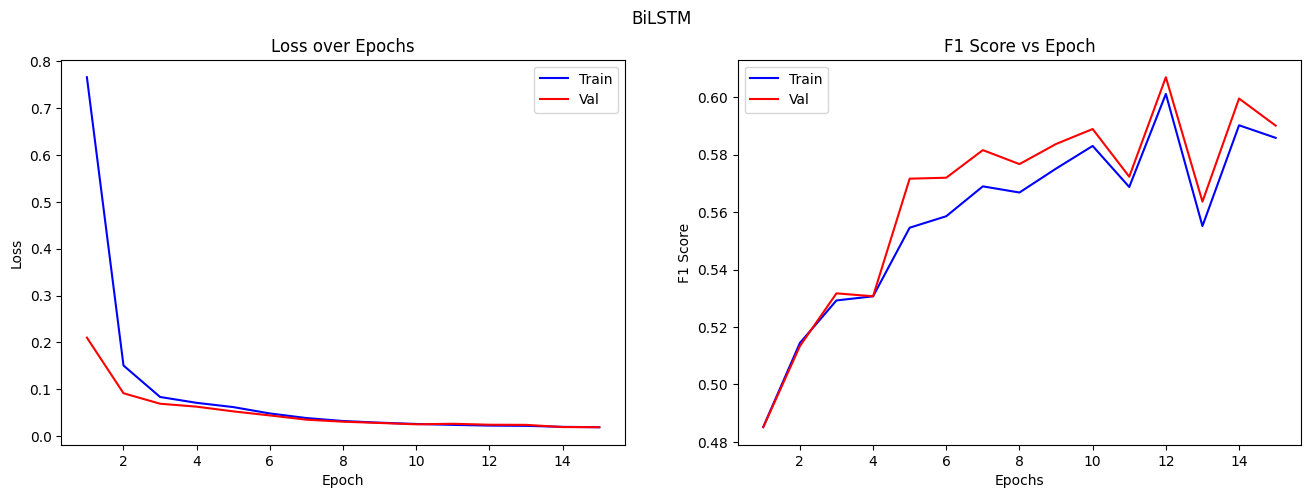

In [52]:
draw_loss_graph(BiLSTM_training,model_name, BiLSTM_f1_callback.train_f1_scores, BiLSTM_f1_callback.val_f1_scores)
save_model(BiLSTM_model,model_name,Embedding_name,Dataset)

## Testing 

In [53]:
loaded_model = load_model(model_name,Embedding_name,Dataset)

Testing accuracy

In [54]:
accuracy = loaded_model.evaluate(X_test, Y_test, verbose = 1)
print(accuracy[1])

11/11 [==============================] - 2s 36ms/step - loss: 0.0217 - accuracy: 0.9731
0.9731472730636597


Testing F1 Score

In [55]:
Y_pred = loaded_model.predict(X_test)
real = get_real(Y_test)
pred = get_pred(Y_pred)

true_labels_flat = [label for sublist in real for label in sublist]
predicted_labels_flat = [label for sublist in pred for label in sublist]

# Compute F1 score
f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')

print("Test F1 Score:", f1)

11/11 [==============================] - 1s 33ms/step
Test F1 Score: 0.5738752823683098


In [ ]:
def Build_bilstm(units)

In [ ]:
def grid_search(X_train,Y_train,X_val,Y_val,input_size):
    keras_model = KerasClassifier(build_fn=Build_bilstm,epochs=20,verbose=3)
    param_grid={}
    grid_search = GridSearchCV(kears_mdoel,param_grid,cv=5,scoring='f1_score',n_jobs=-1,verbose=3)
    grid_search.fit(X_train,Y_train)

    return 